## Programming Exercise 5: Regularized Linear Regression and Bias vs. Variance

In [119]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #fmin_cg to train the linear regression

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8, 5) # set default size of plots

### 1 Regularized Linear Regression

#### 1.1 Visualizing the dataset

In [120]:
# 데이터 불러오기
datafile = 'data/ex5data1.mat'
mat = scipy.io.loadmat( datafile )
X = np.concatenate([mat['X'], mat['Xval'], mat['Xtest']], axis=0)
y = np.concatenate([mat['y'], mat['yval'], mat['ytest']], axis=0)

X의 shape: (54, 1), y의 shape: (54, 1)


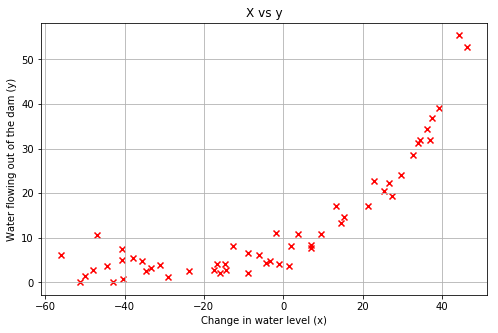

In [121]:
# X, y의 shape를 확인해보고 그래프로 어떻게 나타나는지 그려보자.
print("X의 shape: {}, y의 shape: {}".format(X.shape, y.shape))

def plot(X, y):
    plt.scatter(X, y, c='r', marker='x')
    plt.grid('on')
    plt.title('X vs y')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')

plot(X, y)

#### Train/Val/Test 데이터 나누기
X, y에 대한 총 데이터를 6:2:2의 비율로 나눠서 train/val/test 데이터로 명명해준다. 여기서 데이터가 random하게 섞여있을 지 아닐 지 모르므로 처음에 random하게 섞어주는게 중요하다.

In [122]:
def data_split(X, y):
    # X, y의 index는 서로 매칭되므로 index를 random하게 섞어서 6:2:2의 개수만큼 배분해주자.
    random_indices = np.random.choice(X.shape[0], size=X.shape[0], replace=False)

    # train/val/test 데이터의 개수를 지정하자. 
    num_train = int(X.shape[0] * 0.6)
    num_val = int(X.shape[0] * 0.2)
    num_test = X.shape[0] - num_train - num_val

    # 지정된 개수만큼 배분해주자.
    X_train = X[: num_train]
    X_val = X[num_train: num_train + num_val]
    X_test = X[num_train + num_val:]
    y_train = y[: num_train]
    y_val = y[num_train: num_train + num_val]
    y_test = y[num_train + num_val:]
    
    # 각각의 데이터에 bias를 더해준다. 
    X_train = np.insert(X_train, 0, 1, axis=1)
    X_val = np.insert(X_val, 0, 1, axis=1)
    X_test = np.insert(X_test, 0, 1, axis=1)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

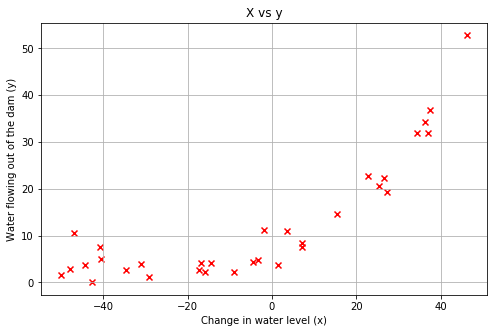

In [123]:
# train으로 뽑은 값들을 그려보자. 
# 그래프를 그려보면 값이 몇 개 듬성듬성 빠지긴 했지만 전체적인 그래프 모양은 비슷하다.
plot(X_train[:, 1], y_train)

#### 1.2 Regularized linear regression cost function

In [124]:
# hypothetis(h) 식 구현
def h(theta,X): 
    return np.dot(X,theta)

# Cost function 구현
def computeCost(theta,X,y,lambda_param=0.): #Cost function
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    """
    m = X.shape[0]
    cost = float((1./(2*m)) * np.sum(np.square(h(theta, X) - y)))
    cost_reg = (float(lambda_param)/(2*m)) * float(np.sum(np.square(theta[1:])))
    return cost + cost_reg

In [125]:
# theta 값이 [[1.], [1.]]일 때 cost를 구해보자. 
theta = np.array([[1.],[1.]])
print(computeCost(theta, X_train, y_train, lambda_param=1.))

340.09509447710894


#### 1.3 Regularized linear regression gradient

In [126]:
def computeGradient(theta, X, y, lambda_param=0.):
    m = X.shape[0]
    grad = (1./float(m)) * np.dot(X.T, (h(theta, X) - y))
    grad_reg = (float(lambda_param) / m) * theta
    grad_reg[0] = 0
    return grad + grad_reg

In [127]:
def computeGradient(theta,X,y,lambda_param=0.):
    m = X.shape[0]
    #grad has same shape as myTheta (2x1)
    h_x = h(theta, X)
    grad = (1./float(m))*np.dot(X.T, (h_x - y))
    grad_reg = (float(lambda_param)/m)*theta
    grad_reg[0] = 0 #don't regulate bias term
    grad_reg.reshape((grad.shape[0],1))
    return grad + grad_reg

In [128]:
# Using theta initialized at [1; 1] you should expect to see a
# gradient of [-15.303016; 598.250744] (with lambda=1)
theta = np.array([[1.],[1.]])
print(computeGradient(theta, X_train, y_train, 1.))

[[ -16.38365446]
 [ 642.51366477]]


#### 1.4 Fitting linear regression

In [129]:
def optimize(initial_theta, X, y, lambda_param=0., num_iterations=2000, learning_rate=0.001):
    theta = initial_theta
    cost_history = []
    for i in range(num_iterations):
        cost = computeCost(theta, X, y, lambda_param)
        cost_history.append(cost)
        dtheta = computeGradient(theta, X, y, lambda_param)
        theta -= learning_rate * dtheta
    return theta, cost_history

In [130]:
initial_theta = np.array([[1.], [1.]])
trained_theta, cost_history = optimize(initial_theta, X_train, y_train, 0)

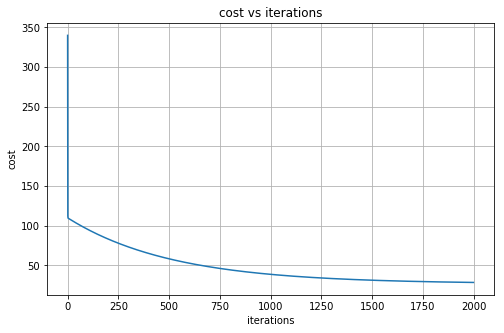

In [131]:
def plot_cost_history(cost_history):
    plt.plot(cost_history)
    plt.grid('on')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title('cost vs iterations')
    plt.show()
plot_cost_history(cost_history)

In [132]:
trained_theta

array([[ 12.21895164],
       [  0.3477011 ]])

우리가 구한 theta가 모델을 얼마나 잘 나타내는지 확인해보자. <br>
--> 위에서 본 그래프에 우리가 구한 모델을 그리면 얼마나 괜찮은지 눈으로 확인할 수 있다.

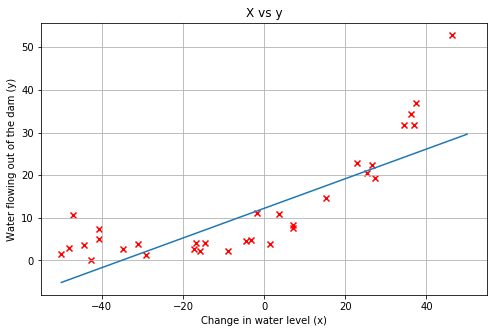

In [133]:
# 먼저, 위에서 본 X_train 그래프를 그리자. 
plot(X_train[:, 1], y_train)

# x는 위에 matrix X랑은 무관하고 x축의 변하는 값을 나타내는 변수이다. 
x = np.linspace(-50, 50, 100)
x = np.reshape(x, [-1, 1])
# bias 추가 
x = np.insert(x, 0, 1, axis=1)
# h를 구하고 그래프로 그린다. 
plt.plot(x[:, 1], h(trained_theta, x))
plt.show()

### 2 Bias-variance

#### 2.1 Learning curves

데이터의 개수에 따라 변하는 train/validation error를 살펴보도록 하자. 

In [134]:
def plot_learningcurve():
    """
    X: X 데이터 (array)
    y: y 데이터 (array)
    """
    num_train = X.shape[0]
    initial_theta = np.array([[1.],[1.]])
    m, train_error, val_error = [], [], []
    for x in range(1,num_train):
        train_subset = X_train[:x,:]
        y_subset = y_train[:x]
        m.append(y_subset.shape[0])
        trained_theta, _ = optimize(initial_theta, train_subset, y_subset, lambda_param=0.)
        train_error.append(computeCost(trained_theta, train_subset, y_subset, lambda_param=0.))
        val_error.append(computeCost(trained_theta, X_val, y_val,lambda_param=0.))
        
    plt.figure(figsize=(8,5))
    plt.plot(m, train_error, label='Train')
    plt.plot(m, val_error, label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)

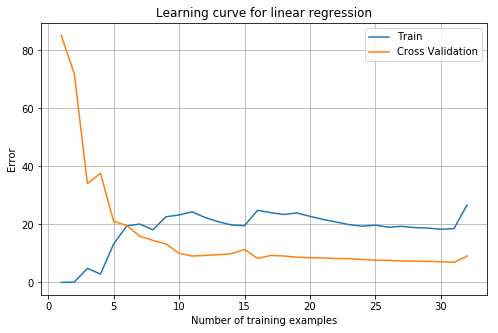

In [135]:
#"You can observe that both the train error and cross validation error are high
# when the number of training examples is increased. This reflects a high bias 
# problem in the model – the linear regression model is too simple and is unable 
# to fit our dataset well."
plot_learningcurve()

### 3 Polynomial regression

여태까지 본 hypothesis 식: $h = \theta \cdot X$

위 식을 변형해서 복잡한 그래프 나타내자: $h = \theta \cdot X_1 + \theta \cdot X_1^2 + ... +\ \theta \cdot X_1^n$

In [136]:
def normalization(x):
    return (x - x.mean())/x.std()

In [137]:
# normalization을 적용한다. 
normed_X = normalization(X)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(normed_X, y)

위와 마찬가지로 그래프로 나타내보자. 

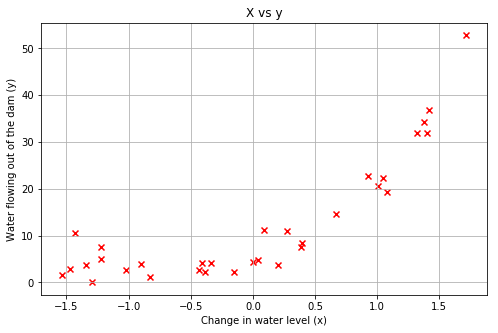

In [138]:
plot(X_train[:, 1], y_train)

$h$ 식을 변경할 예정이므로 그에 맞게 $X, \theta$도 바꿔줘야 한다. $X$에는 다차원의 항이 들어가고 동일한 데이터를 사용한다. 
$\theta$는 차수(degree)에 맞춰서 차원이 증가한다. 

In [139]:
# 먼저, 3차원으로 해보자.
degree = 8

# 다차 함수 구현에 따른 raw 입력 데이터 변경이 필요하다.  
def add_polynomial_value(X, degree):
    add_values = [np.reshape(X[:, 1]**i, [-1, 1]) for i in range(2, degree + 1)]
    return np.concatenate([X] + add_values, axis=1)

In [140]:
normed_X_train = add_polynomial_value(X_train, degree)
normed_X_val = add_polynomial_value(X_val, degree)
normed_X_test = add_polynomial_value(X_test, degree)

h, cost를 구하는 식은 1차원일 때와 동일하게 진행하면 된다. 변경된 $\theta, X$만 잘 입력해주자

In [141]:
# hypothetis(h) 식 구현
def h(theta,X): 
    return np.dot(X,theta)

# Cost function 구현
def computeCost(theta,X,y,lambda_param=0.): #Cost function
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    """
    m = X.shape[0]
    cost = float((1./(2*m)) * np.sum(np.square(h(theta, X) - y)))
    cost_reg = (float(lambda_param)/(2*m)) * float(np.sum(np.square(theta[1:])))
    return cost + cost_reg

In [142]:
# cost가 잘 구해지는 지 확인해보자.
theta = np.ones(shape=[normed_X_train.shape[1], 1])
print(computeCost(theta, normed_X_train, y_train, lambda_param=1.))

282.79888877034824


In [143]:
# gradient 계산
def computeGradient(theta, X, y, lambda_param=0.):
    m = X.shape[0]
    grad = (1./float(m)) * np.dot(X.T, (h(theta, X) - y))
    grad_reg = (float(lambda_param) / m) * theta
    grad_reg[0] = 0
    return grad + grad_reg

In [144]:
# Using theta initialized at [1; 1] you should expect to see a
# gradient of [-15.303016; 598.250744] (with lambda=1)
print(computeGradient(theta, normed_X_train, y_train, 1.))

[[   2.71332473]
 [   5.73479554]
 [  14.7712415 ]
 [  19.24482232]
 [  43.02362398]
 [  57.62844647]
 [ 121.08980531]
 [ 169.57848404]
 [ 341.39636824]]


In [145]:
def optimize(initial_theta, X, y, lambda_param=0., num_iterations=1000, learning_rate=0.001):
    theta = initial_theta
    cost_history = []
    for i in range(num_iterations):
        cost = computeCost(theta, X, y, lambda_param)
        cost_history.append(cost)
        dtheta = computeGradient(theta, X, y, lambda_param)
        theta -= learning_rate * dtheta
    return theta, cost_history

In [146]:
initial_theta = np.ones(shape=[normed_X_train.shape[1], 1])
trained_theta, cost_history = optimize(initial_theta, normed_X_train, y_train)

In [147]:
# 예측 값을 구해보자. 
def prediction(theta, x):
    degree = theta.shape[0] - 1
    pred = 0
    for i in range(0, degree+1):
        pred += theta[i]*(x**i)
    return pred

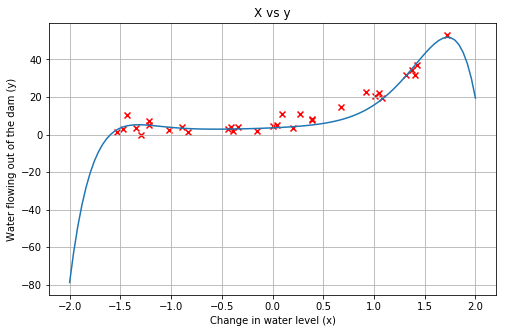

In [148]:
def plot_polynomial(trained_theta):
    x = np.linspace(-2.0, 2.0, 100)
    pred = prediction(trained_theta, x)
    plt.plot(x, pred)
    plt.show()
    
plot(X_train[:, 1], y_train)
plot_polynomial(trained_theta)

In [149]:
def plot_dimensioncurve(degree, lambda_param=0.):
    degrees, train_error, val_error = [], [], []
    for d in range(1, degree + 1):
        degrees.append(d)
        # initial theta 지정
        initial_theta = np.ones([d + 1, 1])
        # degree에 따른 X 구하기
        normed_X_train = add_polynomial_value(X_train, d)
        normed_X_val = add_polynomial_value(X_val, d)
        # theta 구하기
        trained_theta, _ = optimize(initial_theta, normed_X_train, y_train, lambda_param=lambda_param)
        train_error.append(computeCost(trained_theta, normed_X_train, y_train, lambda_param=lambda_param))
        val_error.append(computeCost(trained_theta, normed_X_val, y_val, lambda_param=lambda_param))
        
    plt.figure(figsize=(8,5))
    plt.plot(degrees, train_error, label='Train')
    plt.plot(degrees, val_error, label='Cross Validation')
    plt.legend()
    plt.title('Dimension curve for polynomial regression')
    plt.xlabel('Number of degrees')
    plt.ylabel('Error')
    plt.grid(True)

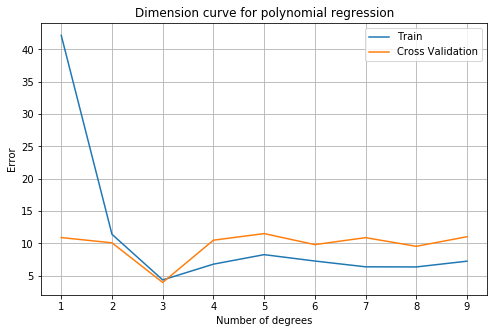

In [150]:
plot_dimensioncurve(10)

위에서 어떤 결과일 때 가장 성능이 좋은가? 그 그래프를 그려보자.

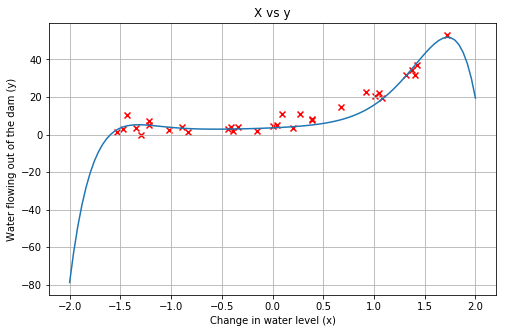

In [151]:
plot(X_train[:, 1], y_train)
plot_polynomial(trained_theta)

## 4. regularizer

lambda에 따라서 어떻게 변하는 지 확인해보자.

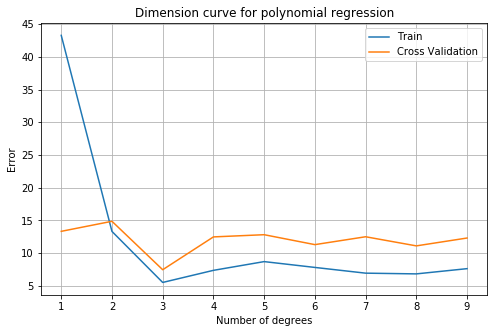

In [152]:
plot_dimensioncurve(degree=10, lambda_param=1)

In [153]:
def plot_lambdacurve(degree):
    lambdas, train_error, val_error = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.], [], []
    for l in lambdas:
        # initial theta 지정
        initial_theta = np.ones([degree + 1, 1])
        # degree에 따른 X 구하기
        normed_X_train = add_polynomial_value(X_train, degree)
        normed_X_val = add_polynomial_value(X_val, degree)
        # theta 구하기
        trained_theta, _ = optimize(initial_theta, normed_X_train, y_train, lambda_param=l)
        train_error.append(computeCost(trained_theta, normed_X_train, y_train, lambda_param=l))
        val_error.append(computeCost(trained_theta, normed_X_val, y_val, lambda_param=l))
        
    plt.figure(figsize=(8,5))
    plt.plot(lambdas, train_error, label='Train')
    plt.plot(lambdas, val_error, label='Cross Validation')
    plt.legend()
    plt.title('lambda curve for polynomial regression')
    plt.xlabel('lambda value')
    plt.ylabel('Error')
    plt.grid(True)

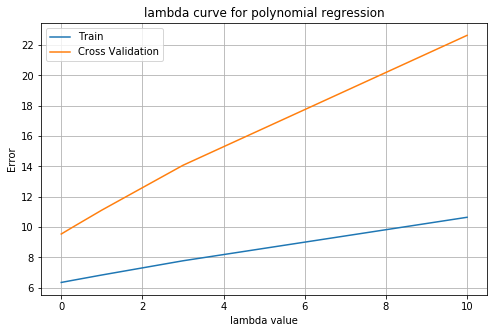

In [154]:
plot_lambdacurve(8)